# BENCHMARK: 

- Train RMSE: 3_448
- Validation RMSE: 3_049

# Imports:

In [260]:
import math
import random
from datetime import date
import warnings
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from functools import partial
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, ExponentiallyWeightedMean, RollingMean
from mlforecast.lgb_cv import LightGBMCV
from mlforecast.target_transforms import Differences, LocalStandardScaler, GlobalSklearnTransformer
from mlforecast.feature_engineering import transform_exog
from utilsforecast.feature_engineering import fourier, trend, pipeline

from numba import njit
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, RobustScaler, FunctionTransformer
from window_ops.rolling import rolling_mean
from xgboost import XGBRegressor


# Suppress warnings
warnings.filterwarnings('ignore')

# MLForecast_Evaluator class definition for models evaluation and prediction:

In [261]:
class MLForecast_Evaluator:
    def __init__(self, fcst, valid, future_df, h=1):
        self.fcst = fcst
        self.valid = valid
        self.future_df = future_df
        self.h = h
        self.mean_rmse_valid = None # To use for filename (mean rmse of all models)
        
        # Generate predictions
        self.predictions = fcst.predict(h=self.h, X_df=future_df)
        
        # Merge predictions with valid set
        self.results = valid.merge(self.predictions, on=['unique_id', 'ds'])
        
        # Get fitted values (train predictions)
        self.train_preds = fcst.forecast_fitted_values()
        
        # Identify model columns
        self.model_columns = list(fcst.models.keys())
        
    def plot_time_series(self, n_samples: int = 4, figsize: tuple = None, random_state: Optional[int] = None):
        """
        Plots the time series for a random sample of unique_ids.
        
        Parameters
        ----------
        """
        
        # Sample random unique_ids
        unique_ids = self.train_preds['unique_id'].unique()
        sampled_ids = np.random.choice(unique_ids, size=min(n_samples, len(unique_ids)), replace=False)
        
        # Calculate grid dimensions
        n_cols = math.ceil(math.sqrt(n_samples))
        n_rows = math.ceil(n_samples / n_cols)
        
        # Calculate adaptive figsize if not provided
        if figsize is None:
            figsize = (7 * n_cols, 4 * n_rows)
        
        # Create subplots
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
        fig.suptitle('Time Series Visualization', fontsize=16)

        axs = axs.flatten() if n_samples > 1 else [axs]

        # List to store handles and labels for the legend
        handles, labels = [], []

        for i, unique_id in enumerate(sampled_ids):
            train_data = self.train_preds[self.train_preds['unique_id'] == unique_id]
            valid_data = self.results[self.results['unique_id'] == unique_id]

            # Plot train data
            h_train, = axs[i].plot(train_data['ds'], train_data['y'], label='Actual (Train)', color='black')
            if 'Actual (Train)' not in labels:
                handles.append(h_train)
                labels.append('Actual (Train)')

            for model in self.model_columns:
                h_model_train, = axs[i].plot(train_data['ds'], train_data[model], label=f'{model} (Train)')
                if f'{model} (Train)' not in labels:
                    handles.append(h_model_train)
                    labels.append(f'{model} (Train)')
            
            # Plot valid data
            h_valid, = axs[i].plot(valid_data['ds'], valid_data['y'], label='Actual (Valid)', color='red', linestyle='--')
            if 'Actual (Valid)' not in labels:
                handles.append(h_valid)
                labels.append('Actual (Valid)')

            for model in self.model_columns:
                h_model_valid = axs[i].scatter(valid_data['ds'], valid_data[model], label=f'{model} (Valid)')
                if f'{model} (Valid)' not in labels:
                    handles.append(h_model_valid)
                    labels.append(f'{model} (Valid)')

            axs[i].set_title(f'Time Series - ID: {unique_id}')
            axs[i].set_xlabel('Date')
            axs[i].set_ylabel('Value')
        
        # Remove any unused subplots
        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])
        
        # Add a single legend for all subplots
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=len(self.model_columns) + 2, fontsize='small')
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend
        plt.show()

    def calculate_metrics(self) -> pd.DataFrame:
        metrics = {}

        for model in self.model_columns:
            model_metrics = {}
            for result_df, name in zip([self.train_preds, self.results], ['train', 'valid']):
                y_true = result_df['y']
                y_pred = result_df[model]

                model_metrics[f'RMSE_{name}'] = np.sqrt(mean_squared_error(y_true, y_pred))
                model_metrics[f'R2_{name}'] = r2_score(y_true, y_pred)

            metrics[model] = model_metrics

        metrics_df = pd.DataFrame(metrics).T

        # Find the model with the lowest validation RMSE
        lowest_rmse_model = metrics_df['RMSE_valid'].idxmin()
        lowest_rmse_value = metrics_df.loc[lowest_rmse_model, 'RMSE_valid']
        
        self.mean_rmse_valid = metrics_df['RMSE_valid'].mean()  # Calculate and store mean RMSE for submission

        print(f"MEAN RMSE_VALID = {self.mean_rmse_valid}\n")
        print(f"Model with lowest RMSE validation is {lowest_rmse_model} with RMSE = {lowest_rmse_value}\n")
        print(metrics_df.sort_values(by='RMSE_valid'))

        return metrics_df.sort_values(by='RMSE_valid')
    
    def plot_feature_importances(self):
        # Initialize an empty DataFrame to store the feature importances
        df = pd.DataFrame()

        # Loop through each model to get its feature importances
        for model in self.model_columns:
            feature_importances = self.fcst.models_[model].feature_importances_
            feature_names = self.fcst.ts.features_order_

            # Create a temporary DataFrame for the current model
            temp_df = pd.DataFrame(feature_importances, columns=[model], index=feature_names)

            # Merge the temporary DataFrame with the main DataFrame
            if df.empty:
                df = temp_df
            else:
                df = df.join(temp_df, how='outer')

        # Fill NaNs with 0 (if any feature is missing in some models)
        df = df.fillna(0)
        # Scale the feature importances between 0 and 1 for each model
        scaler = MinMaxScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

        # Sort features by their average importance
        average_importance = df_scaled.mean(axis=1)
        sorted_features = average_importance.sort_values(ascending=True).index[-50:]

        # Reorder DataFrame according to the sorted feature list
        df_scaled = df_scaled.loc[sorted_features]

        # Plotting the horizontal multi-bar plot
        fig, ax = plt.subplots(figsize=(10, 15))

        # Define the height of the bars and the positions for each group
        bar_height = 0.15
        index = np.arange(len(sorted_features))

        # Loop through each model and plot its feature importances
        for i, model in enumerate(self.model_columns):
            ax.barh(index + i * bar_height, df_scaled[model], bar_height, label=model)

        # Add labels, title, and legend
        ax.set_ylabel('Feature')
        ax.set_xlabel('Scaled Importance')
        ax.set_title('Scaled Feature Importances by Model')
        ax.set_yticks(index + bar_height * (len(self.model_columns) - 1) / 2)
        ax.set_yticklabels(sorted_features)
        ax.legend()

        plt.tight_layout()
        plt.show()


    def plot_metrics(self):
        
        # Create a figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Plot 1: Scatter plot of predicted vs actual values
        for model in self.model_columns:
            # Scatter plot
            sns.scatterplot(x=self.results[model], y=self.results['y'], label=model, ax=ax1, alpha=0.7)
            
            # Fit line
            X = self.results[model].values.reshape(-1, 1)
            y = self.results['y'].values
            reg = LinearRegression().fit(X, y)
            ax1.plot(X, reg.predict(X))

        # Plot the perfect prediction line
        min_val = min(self.results['y'].min(), self.results[self.model_columns].min().min())
        max_val = max(self.results['y'].max(), self.results[self.model_columns].max().max())
        ax1.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect prediction')

        ax1.set_xlabel('Predicted Value')
        ax1.set_ylabel('Actual Value')
        ax1.set_title('Validation Set: Predicted vs Actual')
        ax1.legend(title='Model')

        # Plot 2: Distribution of Residuals
        scaler = RobustScaler()  # RobustScaler is less sensitive to outliers
        palette = sns.color_palette(n_colors=len(self.model_columns))
        
        for i, model in enumerate(self.model_columns):
            # Calculate residuals
            residuals = self.results['y'] - self.results[model]
            
            # Remove infinite values and extreme outliers
            mask = np.isfinite(residuals) & (np.abs(residuals) < np.percentile(np.abs(residuals), 99))
            clean_residuals = residuals[mask]
            
            if len(clean_residuals) > 0:
                # Scale the residuals
                residuals_scaled = scaler.fit_transform(clean_residuals.values.reshape(-1, 1)).flatten()
                
                # Plot KDE with increased bandwidth
                #sns.kdeplot(residuals_scaled, label=model, ax=ax2, bw_adjust=1.5, color=palette[i])
                sns.histplot(residuals_scaled, bins=30, label=model, kde=False, color=palette[i], alpha=0.5, ax=ax2)
                
                # Add rug plot
                #sns.rugplot(residuals_scaled, ax=ax2, color=palette[i], alpha=0.7)
            else:
                print(f"Warning: No valid residuals for model {model}")

        ax2.set_title('Distribution of Scaled Residuals')
        ax2.set_xlabel('Scaled Residual')
        ax2.set_ylabel('Density')
        ax2.legend(title='Model', fontsize=16) #change legend size
        
        # Set x-axis limits for better visibility
        ax2.set_xlim(-5, 5)

        plt.tight_layout()
        plt.show()


    def predict_save_submission(self, model_name, test_index):
        
        if model_name not in self.model_columns:
            raise ValueError(f"Model '{model_name}' not found. Available models are: {', '.join(self.model_columns)}")

        test_preds = self.predictions[self.predictions['ds'].isin(test_index)] #Test index was defined in split
        test_preds = test_preds[['unique_id', model_name]]
        
        # Rename the model column to 'monthly_sales'
        test_preds.rename(columns={model_name: 'monthly_sales'}, inplace=True)

        # Get today's date for the filename
        today = date.today()

        if self.mean_rmse_valid is None:
            print("Warning: mean_rmse_valid has not been calculated yet. Using 'unknown' in filename.")
            mean_rmse_str = "unknown"
        else:
            mean_rmse_str = f"{self.mean_rmse_valid:.4f}"  # Format to 4 decimal places

        output_filename = f"submissions\submission_{model_name}_mean_valid_RMSE_{mean_rmse_str}_{today}.csv"
        test_preds.to_csv(output_filename, index=False)

        print(f"Submission file '{output_filename}' has been created successfully.")

        return test_preds

# Data Load:

In [262]:
path = r'.\data\ts_kaggle_train.csv'
data = pd.read_csv(path, index_col=0, parse_dates=['date'])

In [263]:
data.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0


In [264]:
data.tail()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
14479,2015-10-31,7_5822,21,7,35,5822,NaN,NaN
14480,2015-10-31,7_6185,21,7,30,6185,NaN,NaN
14481,2015-10-31,7_6497,21,7,28,6497,NaN,NaN
14482,2015-10-31,7_7856,21,7,28,7856,NaN,NaN
14483,2015-10-31,7_7893,21,7,6,7893,NaN,NaN


### Transform to MLforecast nomenclature and save columns in useful lists:

In [265]:
# target = y
data.rename(columns={'date': 'ds', 'monthly_sales': 'y'}, inplace=True)

In [266]:
core_features = ['ds','unique_id']
static_features = ['city_id', 'shop_id', 'item_category_id', 'item_id']

# EDA

In [267]:
data["unique_id"].nunique() # we have 426 unique_ids = 426 time series

426

In [268]:
print(f"Min date is {data["ds"].min()}\nMax date is {data["ds"].max()}")

Min date is 2013-01-31 00:00:00
Max date is 2015-10-31 00:00:00


In [269]:
#data.isnull().sum()

In [270]:
#data['y'].hist(bins=30);
#plt.title("Target distribution in data");

In [271]:
#data['ds'].dt.month.hist(bins=12);
#plt.title("Months distribution in data");

In [272]:
# Top sales months are 12 and 1
data.groupby('ds')['y'].sum().sort_values(ascending = False).head(10)

ds
2014-12-31    4874.0
2013-12-31    4514.0
2015-01-31    4223.0
2014-11-30    3681.0
2014-01-31    3508.0
2014-02-28    3462.0
2015-02-28    3436.0
2014-03-31    3383.0
2014-08-31    3309.0
2015-03-31    3245.0
Name: y, dtype: float64

Iterating with previous plot I observed that item 20949 has a quite constant pattern, which could be detrimental to our models

In [273]:
plot_data = data[core_features+['y']].copy()
plot_data['y_diff'] = plot_data.groupby('unique_id')['y'].diff()
plot_data['y_log'] = plot_data['y'].apply(np.log1p)
plot_data['y_log_diff'] = plot_data.groupby('unique_id')['y_log'].diff()

In [274]:
plot_data

,ds,unique_id,y,y_diff,y_log,y_log_diff
0,2013-01-31,12_11365,30.0,NaN,3.433987,NaN
1,2013-01-31,12_11369,30.0,NaN,3.433987,NaN
2,2013-01-31,12_11370,30.0,NaN,3.433987,NaN
3,2013-01-31,12_11373,6.0,NaN,1.945910,NaN
4,2013-01-31,12_12231,3.0,NaN,1.386294,NaN
...,...,...,...,...,...,...
14479,2015-10-31,7_5822,NaN,NaN,NaN,NaN
14480,2015-10-31,7_6185,NaN,NaN,NaN,NaN
14481,2015-10-31,7_6497,NaN,NaN,NaN,NaN
14482,2015-10-31,7_7856,NaN,NaN,NaN,NaN


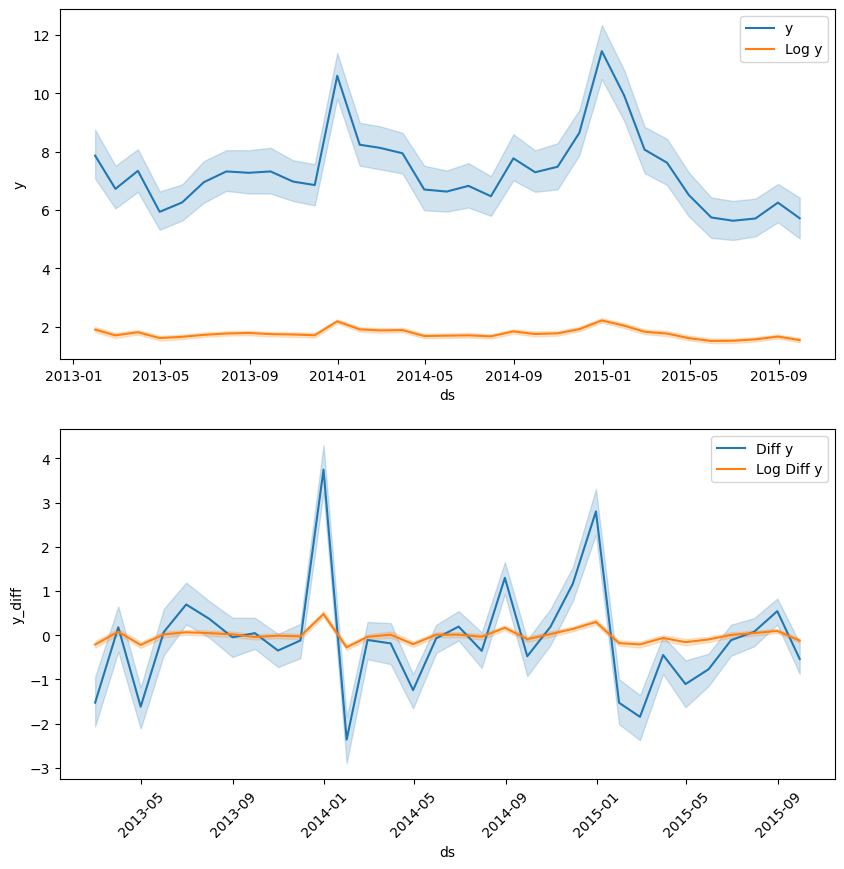

In [275]:
# Plot item 20949 or 492 sales
fig = plt.figure(figsize = (10, 10))
ax1, ax2 = fig.subplots(2, 1)

sns.lineplot(data = plot_data, x = "ds", y = "y", ax=ax1, label='y'); # Accumulated monthly sales
plt.xticks(rotation=45);

sns.lineplot(data = plot_data, x = "ds", y = "y_diff", ax=ax2, label='Diff y');
plt.xticks(rotation=45);

sns.lineplot(data = plot_data, x = "ds", y = "y_log", ax=ax1, label='Log y');
plt.xticks(rotation=45);

sns.lineplot(data = plot_data, x = "ds", y = "y_log_diff", ax=ax2, label='Log Diff y');
plt.xticks(rotation=45);

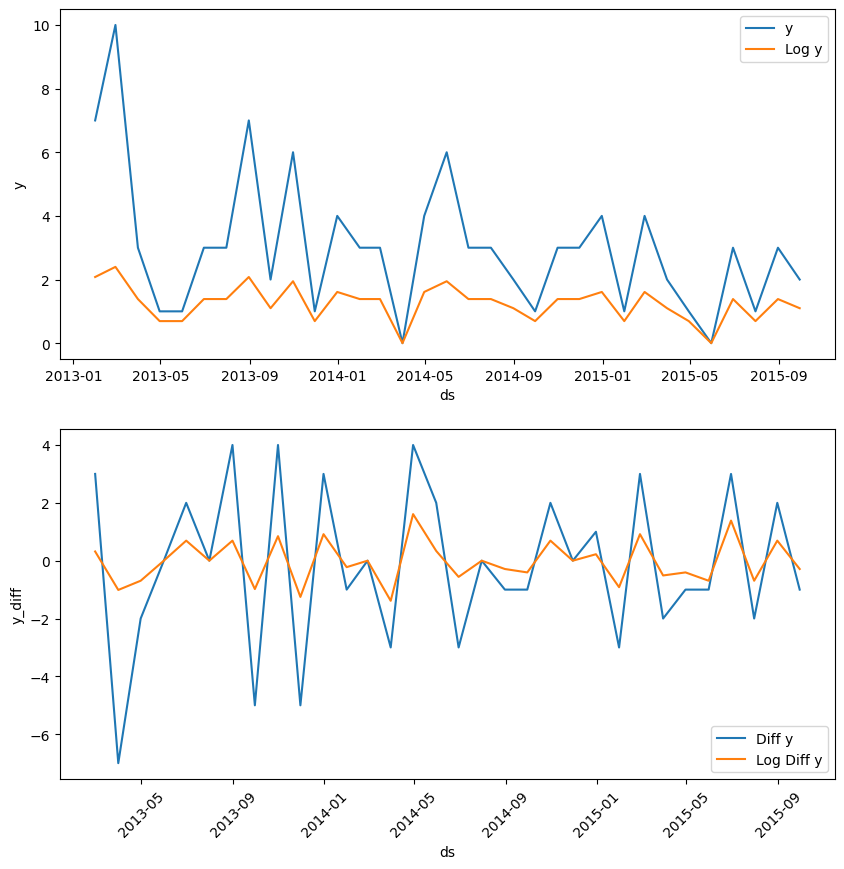

In [276]:
# Plot item 20949 or 492 sales
fig = plt.figure(figsize = (10, 10))
ax1, ax2 = fig.subplots(2, 1)

temp_df = plot_data[plot_data['unique_id'] == "7_6185"]
#temp_df = temp_df[temp_df['item_id'] == 20949]

sns.lineplot(data = temp_df, x = "ds", y = "y", ax=ax1, label='y'); # Accumulated monthly sales
plt.xticks(rotation=45);

sns.lineplot(data = temp_df, x = "ds", y = "y_diff", ax=ax2, label='Diff y');
plt.xticks(rotation=45);

sns.lineplot(data = temp_df, x = "ds", y = "y_log", ax=ax1, label='Log y');
plt.xticks(rotation=45);

sns.lineplot(data = temp_df, x = "ds", y = "y_log_diff", ax=ax2, label='Log Diff y');
plt.xticks(rotation=45);

# NaN imputation:

- First test:
    - Imput target with 0 (NaN means no sales)
    - Imput monthly_average_price with fill with previous value (bfill) and next value (ffill)

- Second test: KNNimputer

In [277]:
"""pivot_df = data.pivot_table(
    index = "ds", 
    columns="unique_id", 
    values="y").isnull()

sns.heatmap(pivot_df)"""

'pivot_df = data.pivot_table(\n    index = "ds", \n    columns="unique_id", \n    values="y").isnull()\n\nsns.heatmap(pivot_df)'

In [278]:
"""pivot_df = data.pivot_table(
    index = "ds", 
    columns="unique_id", 
    values="monthly_average_price").isnull()

sns.heatmap(pivot_df)"""

'pivot_df = data.pivot_table(\n    index = "ds", \n    columns="unique_id", \n    values="monthly_average_price").isnull()\n\nsns.heatmap(pivot_df)'

### First test:

In [279]:
"""data.fillna({"y":0}, inplace = True)

data["monthly_average_price"] = data.groupby("unique_id", group_keys = False)["monthly_average_price"].apply(
    lambda series: series.bfill().ffill()
)

# To compare to KNNimputer:
data['month'] = data['ds'].dt.month
data['year'] = data['ds'].dt.year
data['quarter'] = data['ds'].dt.quarter
data['christmas_month'] = data['ds'].dt.month == 12
"""

'data.fillna({"y":0}, inplace = True)\n\ndata["monthly_average_price"] = data.groupby("unique_id", group_keys = False)["monthly_average_price"].apply(\n    lambda series: series.bfill().ffill()\n)\n\n# To compare to KNNimputer:\ndata[\'month\'] = data[\'ds\'].dt.month\ndata[\'year\'] = data[\'ds\'].dt.year\ndata[\'quarter\'] = data[\'ds\'].dt.quarter\ndata[\'christmas_month\'] = data[\'ds\'].dt.month == 12\n'

### Second test: KNNimputer

In [280]:
data.isnull().sum()

ds                          0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
y                         728
dtype: int64

In [281]:
# Create a copy of the original data to avoid modifications
"""data_temp = data.copy()

# Extract time-based features from the 'ds' column because KNN needs numeric features
data_temp['month'] = data_temp['ds'].dt.month
data_temp['year'] = data_temp['ds'].dt.year
data_temp['quarter'] = data_temp['ds'].dt.quarter
data_temp['around_Xmas'] = data_temp['ds'].dt.month.isin([1,12])
data_temp['before_Xmas'] = data_temp['ds'].dt.month == 12


# Columns to impute using KNN
cols_with_missing = ['monthly_average_price', 'y']

# Drop unnecessary columns and create a copy for imputation
data_impute = data_temp.drop(columns=['ds', 'unique_id']).copy()

# Fit and transform the KNN imputer
imputer = KNNImputer(n_neighbors=3)
imputed_values = imputer.fit_transform(data_impute)

# Create a DataFrame with the imputed values
imputed_df = pd.DataFrame(imputed_values, columns=data_impute.columns, index=data_impute.index)

# Merge the imputed columns with the original data, excluding the imputed ones
data_final = imputed_df[cols_with_missing].merge(
    data_temp.drop(columns=cols_with_missing), how='right', left_index=True, right_index=True
)

data = data_final.copy()"""

"data_temp = data.copy()\n\n# Extract time-based features from the 'ds' column because KNN needs numeric features\ndata_temp['month'] = data_temp['ds'].dt.month\ndata_temp['year'] = data_temp['ds'].dt.year\ndata_temp['quarter'] = data_temp['ds'].dt.quarter\ndata_temp['around_Xmas'] = data_temp['ds'].dt.month.isin([1,12])\ndata_temp['before_Xmas'] = data_temp['ds'].dt.month == 12\n\n\n# Columns to impute using KNN\ncols_with_missing = ['monthly_average_price', 'y']\n\n# Drop unnecessary columns and create a copy for imputation\ndata_impute = data_temp.drop(columns=['ds', 'unique_id']).copy()\n\n# Fit and transform the KNN imputer\nimputer = KNNImputer(n_neighbors=3)\nimputed_values = imputer.fit_transform(data_impute)\n\n# Create a DataFrame with the imputed values\nimputed_df = pd.DataFrame(imputed_values, columns=data_impute.columns, index=data_impute.index)\n\n# Merge the imputed columns with the original data, excluding the imputed ones\ndata_final = imputed_df[cols_with_missing].me

In [282]:
# replace imputed values in target to 0 for date 2015-10-31 (test data)
test_index = [sorted(list(data["ds"].unique()))[-1]]
data['y'] = np.where(data['ds'].isin(test_index), 0, data['y'])

In [283]:
#data.to_csv(r'.\data\ts_kaggle_train_imputed.csv',index=False)

# Feature engineering:

Already created month, year, quarter, and christmas_month features

In [284]:
data = pd.read_csv(r'.\data\ts_kaggle_train_imputed.csv', parse_dates=['ds'])

### Seasonality and trend

In [285]:
features = [
    trend,
    #partial(fourier, season_length=6, k=3),
    partial(fourier, season_length=12, k=3),
]

data = pipeline(
    data,
    features=features,
    freq='M',
    h=1,
)[0]

### Special dates:
- January: New Year's Day, Christmas (Orthodox)
- February: Defender of the Fatherland Day
- March: International Women's Day

Also add october as boolean because its month to predict:
- Month to predict and before if there is trend

In [286]:
data['nr_of_holidays'] = data['month'].map({1: 2, 2: 1, 3: 1}).fillna(0)

In [287]:
data['month_to_predict'] = data['month'] == 10
data['month_before_predict'] = data['month'] == 9

### Revenue

In [288]:
def create_lags_diffs(df, target, lags, diff=False):
    for lag in lags:
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)
        if diff:
            df[f'{target}_diff_{lag}'] = df[target].diff(lag)
    return df

In [289]:
data["revenue"] = data["y"] * data["monthly_average_price"]

In [290]:
data = create_lags_diffs(data, "revenue", [1, 2, 3])

### Grouped calculations:

In [291]:
"""def build_ts_features(df, cols_to_group, target_column, lags, aggfunc):

    # Error control for lags
    if not isinstance(lags, list):
        raise ValueError("Lags should be a list of integers.")
    
    # Create a new name for columns based on the grouping list
    new_name = "_".join(cols_to_group)
    
    # Set the index and perform grouping, resampling, and aggregation in one step
    grouped_df = (
        df.set_index("ds")
        .groupby(cols_to_group + [pd.Grouper(freq="M")])
        [target_column]
        .agg(aggfunc)
        .reset_index()
    )
    
    # Generate lag and diff features for specified lags
    for n in lags:
        lag_col_name = f"{new_name}_{target_column}_{aggfunc.__name__}_lag_{n}"
        grouped_df[lag_col_name] = grouped_df.groupby(cols_to_group)[target_column].shift(n)
    
    # Merge the generated features back into the original DataFrame
    merge_cols = ['ds', target_column] + cols_to_group
    df = pd.merge(df, grouped_df, on=merge_cols, how='left')
    
    return df"""

'def build_ts_features(df, cols_to_group, target_column, lags, aggfunc):\n\n    # Error control for lags\n    if not isinstance(lags, list):\n        raise ValueError("Lags should be a list of integers.")\n    \n    # Create a new name for columns based on the grouping list\n    new_name = "_".join(cols_to_group)\n    \n    # Set the index and perform grouping, resampling, and aggregation in one step\n    grouped_df = (\n        df.set_index("ds")\n        .groupby(cols_to_group + [pd.Grouper(freq="M")])\n        [target_column]\n        .agg(aggfunc)\n        .reset_index()\n    )\n    \n    # Generate lag and diff features for specified lags\n    for n in lags:\n        lag_col_name = f"{new_name}_{target_column}_{aggfunc.__name__}_lag_{n}"\n        grouped_df[lag_col_name] = grouped_df.groupby(cols_to_group)[target_column].shift(n)\n    \n    # Merge the generated features back into the original DataFrame\n    merge_cols = [\'ds\', target_column] + cols_to_group\n    df = pd.merge(d

In [292]:
cols_not_to_transform = data.columns.to_list()

In [293]:
#This one does not creates lags

def build_ts_features(df, cols_to_group, target_column, aggfunc):
    """
    Build time series features using grouping and aggregation.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    cols_to_group (list): Columns to group by.
    target_column (str): Column name for the target variable.
    aggfunc (function): Aggregation function to apply (e.g., np.mean, np.sum).

    Returns:
    pd.DataFrame: Original DataFrame with added time series features.
    """
    
    # Create a new name for columns based on the grouping list
    new_name = "_".join(cols_to_group)
    
    # Perform grouping and aggregation
    grouped_df = (
        df.groupby(cols_to_group + [pd.Grouper(key='ds', freq='M')])
        [target_column]
        .agg(aggfunc)
        .reset_index()
    )
    
    # Create the new column name and assign the aggregated values
    new_col_name = f"{new_name}_{target_column}_{aggfunc.__name__}"
    grouped_df = grouped_df.rename(columns={target_column: new_col_name})
    
    # Merge the generated features back into the original DataFrame
    merge_cols = ['ds'] + cols_to_group
    df = pd.merge(df, grouped_df, on=merge_cols, how='left')
    
    return df

In [294]:
print(f"Initial DataFrame shape: {data.shape}")

targets = ['y', 'revenue']
groups = [
    ['shop_id'], 
    ['item_id'], 
    ['item_category_id'], 
    ['city_id'],
    ['before_Xmas'],
    ['month'],
    ['quarter'],
    ['around_Xmas'],
    ['year'],
    ['city_id','shop_id'],
    ['city_id', 'item_id'],
    ['shop_id', 'item_category_id'],
    ['month', 'city_id'],
    ['month', 'item_id'],
    ['quarter', 'before_Xmas']
]
agg_functions = [np.sum, np.mean, np.max, np.min]

for target in targets:
    for group in groups:
        for agg_func in agg_functions:
            data = build_ts_features(
                                    df=data,
                                    cols_to_group=group,
                                    target_column=target,
                                    aggfunc=agg_func,
                                )
            
print(f"Final DataFrame shape: {data.shape}")

Initial DataFrame shape: (14484, 27)


Final DataFrame shape: (14484, 147)


In [295]:
print(f"Initial DataFrame shape: {data.shape}")

targets = ['monthly_average_price']
groups = [
    ['item_category_id'],
    ['city_id'],  
    ['city_id', 'item_category_id'],
    
]
agg_functions = [np.mean, np.max]

for target in targets:
    for group in groups:
        for agg_func in agg_functions:
            data = build_ts_features(
                                    df=data,
                                    cols_to_group=group,
                                    target_column=target,
                                    aggfunc=agg_func,
                                )
            
print(f"Final DataFrame shape: {data.shape}")

Initial DataFrame shape: (14484, 147)
Final DataFrame shape: (14484, 153)


### RUB/USD

In [296]:
import yfinance as yf

start_date = "2013-01-01"
end_date = "2015-11-01"

# Symbol for RUB/USD
symbol = "RUB=X"

# Download the data
rub_usd = yf.download(symbol, start=start_date, end=end_date, interval="1mo")['Close'].reset_index()

rub_usd['year'] = rub_usd['Date'].dt.year
rub_usd['month'] = rub_usd['Date'].dt.month
rub_usd['Close_diff'] = rub_usd['Close'].diff()

# Merge the RUB/USD data with the main DataFrame:
data = pd.merge(data, rub_usd.drop('Date', axis=1), how='left', on=['year', 'month'])

[*********************100%%**********************]  1 of 1 completed


### Variance

In [297]:
#data['variance'] = data.groupby('unique_id')['y'].transform(np.var)
data['std'] = data.groupby('unique_id')['y'].transform(np.std)

## Transformation of exogenous dynamic features:

In [298]:
cols_to_transf = list((set(data.columns) - set(cols_not_to_transform)))

In [299]:
temp_transf = transform_exog(data[cols_to_transf+core_features], lags=[1,2], 
                             lag_transforms={1: [ExpandingMean()]})

In [300]:
data = pd.merge(data.drop(cols_to_transf, axis=1), 
                temp_transf.drop(cols_to_transf+core_features, axis=1),
                how='left', left_index=True, right_index=True)

In [301]:
data

,monthly_average_price,y,ds,unique_id,city_id,shop_id,item_category_id,item_id,month,year,...,item_id_revenue_max_expanding_mean_lag1,around_Xmas_y_max_lag1,around_Xmas_y_max_lag2,around_Xmas_y_max_expanding_mean_lag1,shop_id_revenue_sum_lag1,shop_id_revenue_sum_lag2,shop_id_revenue_sum_expanding_mean_lag1,city_id_item_id_revenue_mean_lag1,city_id_item_id_revenue_mean_lag2,city_id_item_id_revenue_mean_expanding_mean_lag1
0,1511.512626,30.0,2013-01-31,12_11365,16,12,9,11365,1,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,572.715278,30.0,2013-01-31,12_11369,16,12,9,11369,1,2013,...,45345.378788,30.0,NaN,30.0,213263.540693,NaN,213263.540693,45345.378788,NaN,45345.378788
2,699.776786,30.0,2013-01-31,12_11370,16,12,9,11370,1,2013,...,43369.876894,30.0,30.0,30.0,236417.673786,213263.540693,224840.607239,41394.375000,45345.378788,43369.876894
3,548.900000,6.0,2013-01-31,12_11373,16,12,9,11373,1,2013,...,61437.953644,30.0,30.0,30.0,271836.568071,236417.673786,240505.927517,97574.107143,41394.375000,61437.953644
4,350.000000,3.0,2013-01-31,12_12231,16,12,49,12231,1,2013,...,56814.442505,30.0,30.0,30.0,231494.439542,271836.568071,238253.055523,42943.909091,97574.107143,56814.442505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14479,1049.000000,0.0,2015-10-31,7_5822,21,7,35,5822,10,2015,...,26286.163667,30.0,30.0,30.0,57753.163846,72400.250000,56519.618571,8520.000000,5780.000000,7668.860094
14480,499.000000,0.0,2015-10-31,7_6185,21,7,30,6185,10,2015,...,26087.274878,30.0,30.0,30.0,72801.142456,57753.163846,57062.336034,2490.000000,8520.000000,7496.231425
14481,782.333333,0.0,2015-10-31,7_6497,21,7,28,6497,10,2015,...,25805.104721,30.0,30.0,30.0,42052.860000,72801.142456,56578.159388,2690.000000,2490.000000,7341.191701
14482,932.333333,0.0,2015-10-31,7_7856,21,7,28,7856,10,2015,...,25387.757698,30.0,30.0,30.0,50802.991667,42052.860000,56397.685396,2490.000000,2690.000000,7189.591961


# Train, Validation, Test Split & Future dataset creation:

Future_df incorporates all exogenous dynamic features and is passed before prediction.

In [302]:
train_index = sorted(list(data["ds"].unique()))[:-2]
valid_index = [sorted(list(data["ds"].unique()))[-2]]
test_index = [sorted(list(data["ds"].unique()))[-1]]

print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valid_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [Timestamp('2013-01-31 00:00:00'), Timestamp('2013-02-28 00:00:00')] - ... - [Timestamp('2015-07-31 00:00:00'), Timestamp('2015-08-31 00:00:00')]

Our validation index is [Timestamp('2015-09-30 00:00:00')]

Our test/prediction index is [Timestamp('2015-10-31 00:00:00')]



**Drop Revenue cause of leakage**

In [303]:
data.drop('revenue', axis=1, inplace=True)

In [316]:
train = data.loc[data['ds'].isin(train_index)]
valid = data.loc[data['ds'].isin(valid_index)]
test = data.loc[data['ds'].isin(test_index)]

In [317]:
all_features = list(train.columns)
dynamic_features = list(set(all_features) - set(static_features) - set('y'))

In [318]:
future_df = data[dynamic_features]

# Recursive feature selection using recursive feature elimination:

In [322]:
train = train.set_index(['ds', 'unique_id']).dropna()

X = train[random.sample(dynamic_features, 50)]
y = train['y']

from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

from sklearn.feature_selection import RFE

# Create XGBoost model
model = XGBRegressor(random_state=42)

# Perform Recursive Feature Elimination
n_features_to_select = 5  # for example
rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)
rfe = rfe.fit(X_train_scaled, y_train)

# Get selected features
selected_features = X.columns[rfe.support_].tolist()

print("Selected features:")
print(selected_features)

# MLforecast model creation:

## Models:

In [200]:
# Define models with built-in feature selection and regularization
rf = RandomForestRegressor(
    n_estimators=200,
    max_features='sqrt',  # Built-in feature selection
    min_samples_leaf=5,   # Regularization to prevent overfitting
    random_state=42,
)

xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,          # Limit tree depth to prevent overfitting
    colsample_bytree=0.8, # Feature selection: use 80% of features per tree
    subsample=0.8,        # Use 80% of samples per tree, adding regularization
    reg_lambda=1,         # L2 regularization
    random_state=42
)

cb = CatBoostRegressor(
    iterations=200,
    learning_rate=0.05,
    depth=5,              # Limit tree depth
    l2_leaf_reg=3,        # L2 regularization
    rsm=0.8,              # Random subspace method: use 80% of features per tree
    subsample=0.8,        # Use 80% of samples per tree
    random_state=42,
    silent=True
)

models = [rf, xgb, cb]

## Target lags and transformations:

In [201]:
@njit
def diff(x, lag):
    x2 = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        x2[i] = x[i] - x[i-lag]
    return x2

sk_log1p = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

fcst = MLForecast(
    
    models=models,
    freq='M',
    lags=[1, 2, 3, 6],
    lag_transforms={
        1: [
            (rolling_mean, 2), (rolling_mean, 3), (rolling_mean, 6),
            (diff, 1), (diff, 3), (diff, 6),
            ExpandingMean(), ExponentiallyWeightedMean(alpha=0.2),
        ],
        2: [
            (rolling_mean, 3), (rolling_mean, 6),
            (diff, 2), (diff, 6),
            ExpandingMean()
        ],
        3: [
            (rolling_mean, 3), (rolling_mean, 6),
            (diff, 3),
            ExpandingMean(),
        ],
        6: [
            (rolling_mean, 3),
            ExpandingMean(), ExponentiallyWeightedMean(alpha=0.2),
        ]
    },
    target_transforms=[GlobalSklearnTransformer(sk_log1p), Differences([1])],
    num_threads=6
)

In [202]:
# This is the transformation of the train set:
transf_train = fcst.preprocess(train, id_col='unique_id', time_col='ds', target_col='y', dropna=False)
transf_train.head()

,monthly_average_price,y,ds,unique_id,city_id,shop_id,item_category_id,item_id,month,year,...,diff_lag2_lag2,diff_lag2_lag6,expanding_mean_lag2,rolling_mean_lag3_window_size3,rolling_mean_lag3_window_size6,diff_lag3_lag3,expanding_mean_lag3,rolling_mean_lag6_window_size3,expanding_mean_lag6,exponentially_weighted_mean_lag6_alpha0.2
0,1511.512626,NaN,2013-01-31,12_11365,16,12,9,11365,1,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,572.715278,NaN,2013-01-31,12_11369,16,12,9,11369,1,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,699.776786,NaN,2013-01-31,12_11370,16,12,9,11370,1,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,548.900000,NaN,2013-01-31,12_11373,16,12,9,11373,1,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,350.000000,NaN,2013-01-31,12_12231,16,12,49,12231,1,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Train and fit all models

In [2462]:
fcst.fit(train, fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=static_features)

MLForecast(models=[RandomForestRegressor, XGBRegressor, CatBoostRegressor], freq=M, lag_features=['lag1', 'lag2', 'lag3', 'lag6', 'rolling_mean_lag1_window_size2', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6', 'diff_lag1_lag1', 'diff_lag1_lag3', 'diff_lag1_lag6', 'expanding_mean_lag1', 'exponentially_weighted_mean_lag1_alpha0.2', 'rolling_mean_lag2_window_size3', 'rolling_mean_lag2_window_size6', 'diff_lag2_lag2', 'diff_lag2_lag6', 'expanding_mean_lag2', 'rolling_mean_lag3_window_size3', 'rolling_mean_lag3_window_size6', 'diff_lag3_lag3', 'expanding_mean_lag3', 'rolling_mean_lag6_window_size3', 'expanding_mean_lag6', 'exponentially_weighted_mean_lag6_alpha0.2'], date_features=[], num_threads=6)

# Evaluate on validation set (h=1)

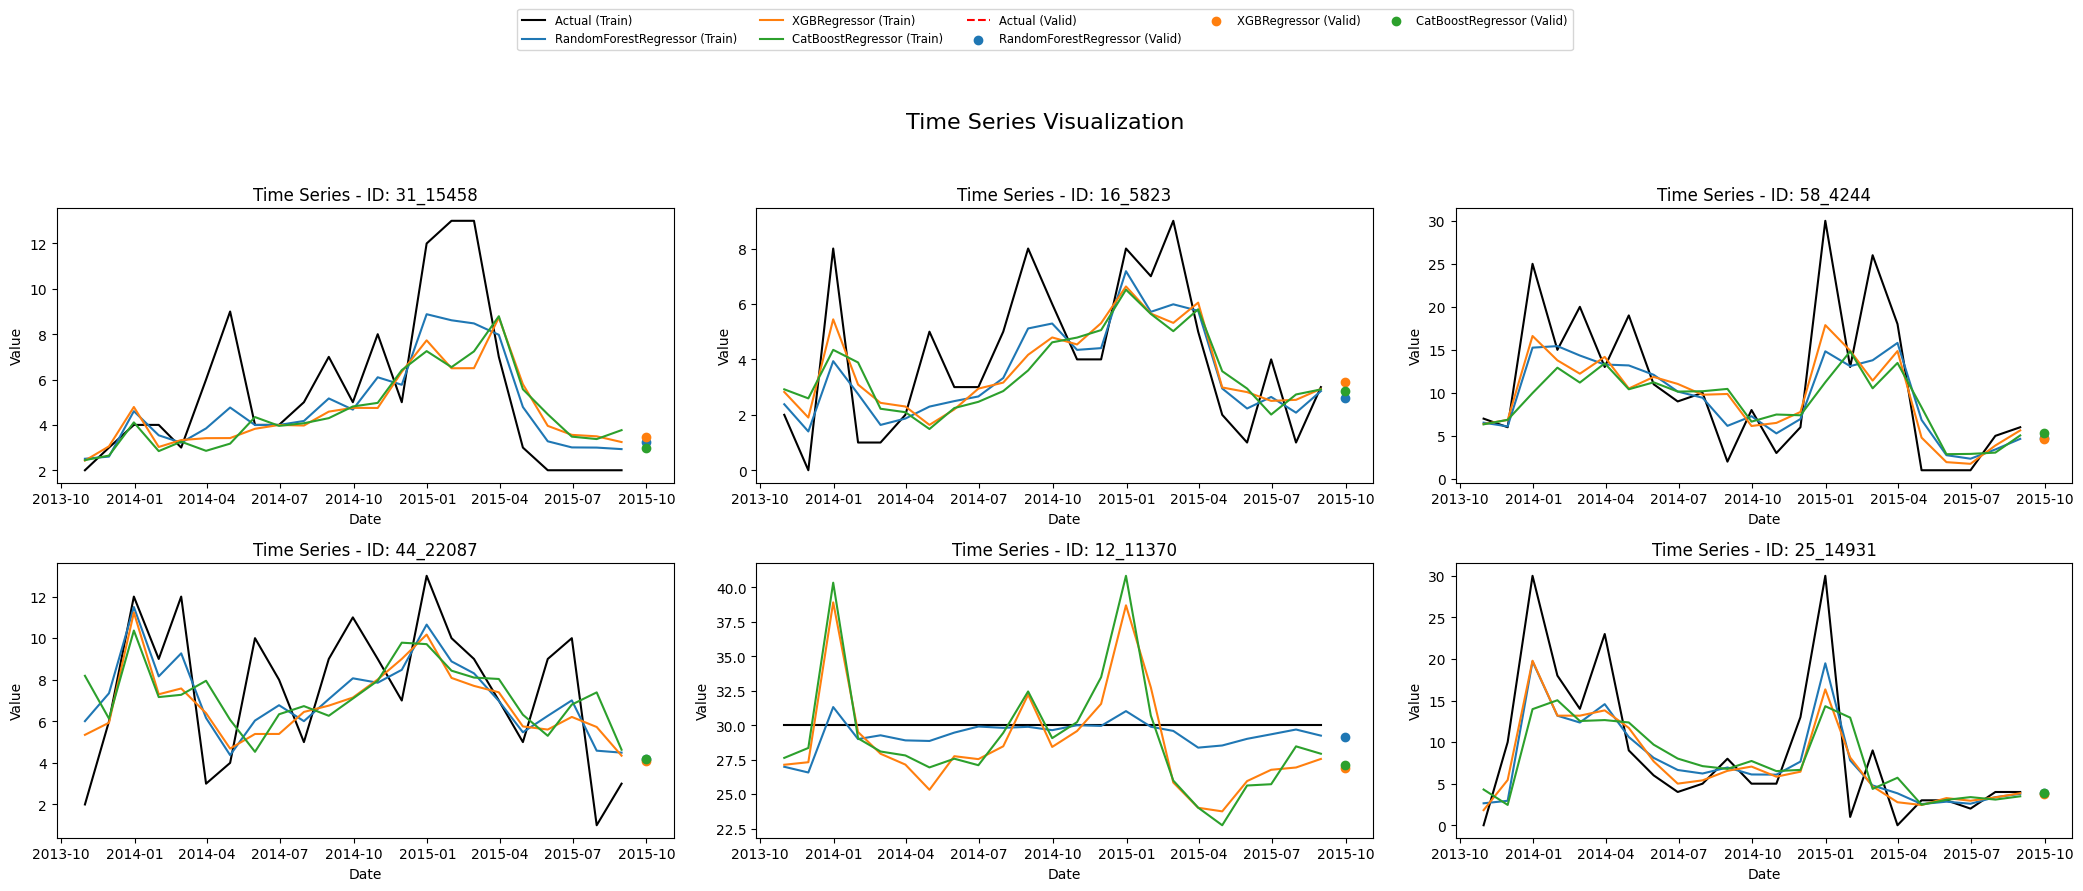

MEAN RMSE_VALID = 2.8690122011483545

Model with lowest RMSE validation is RandomForestRegressor with RMSE = 2.842704631384985

                       RMSE_train  R2_train  RMSE_valid  R2_valid
RandomForestRegressor    2.652997  0.893381    2.842705  0.851547
CatBoostRegressor        3.682212  0.794610    2.872176  0.848453
XGBRegressor             3.120013  0.852540    2.892156  0.846337


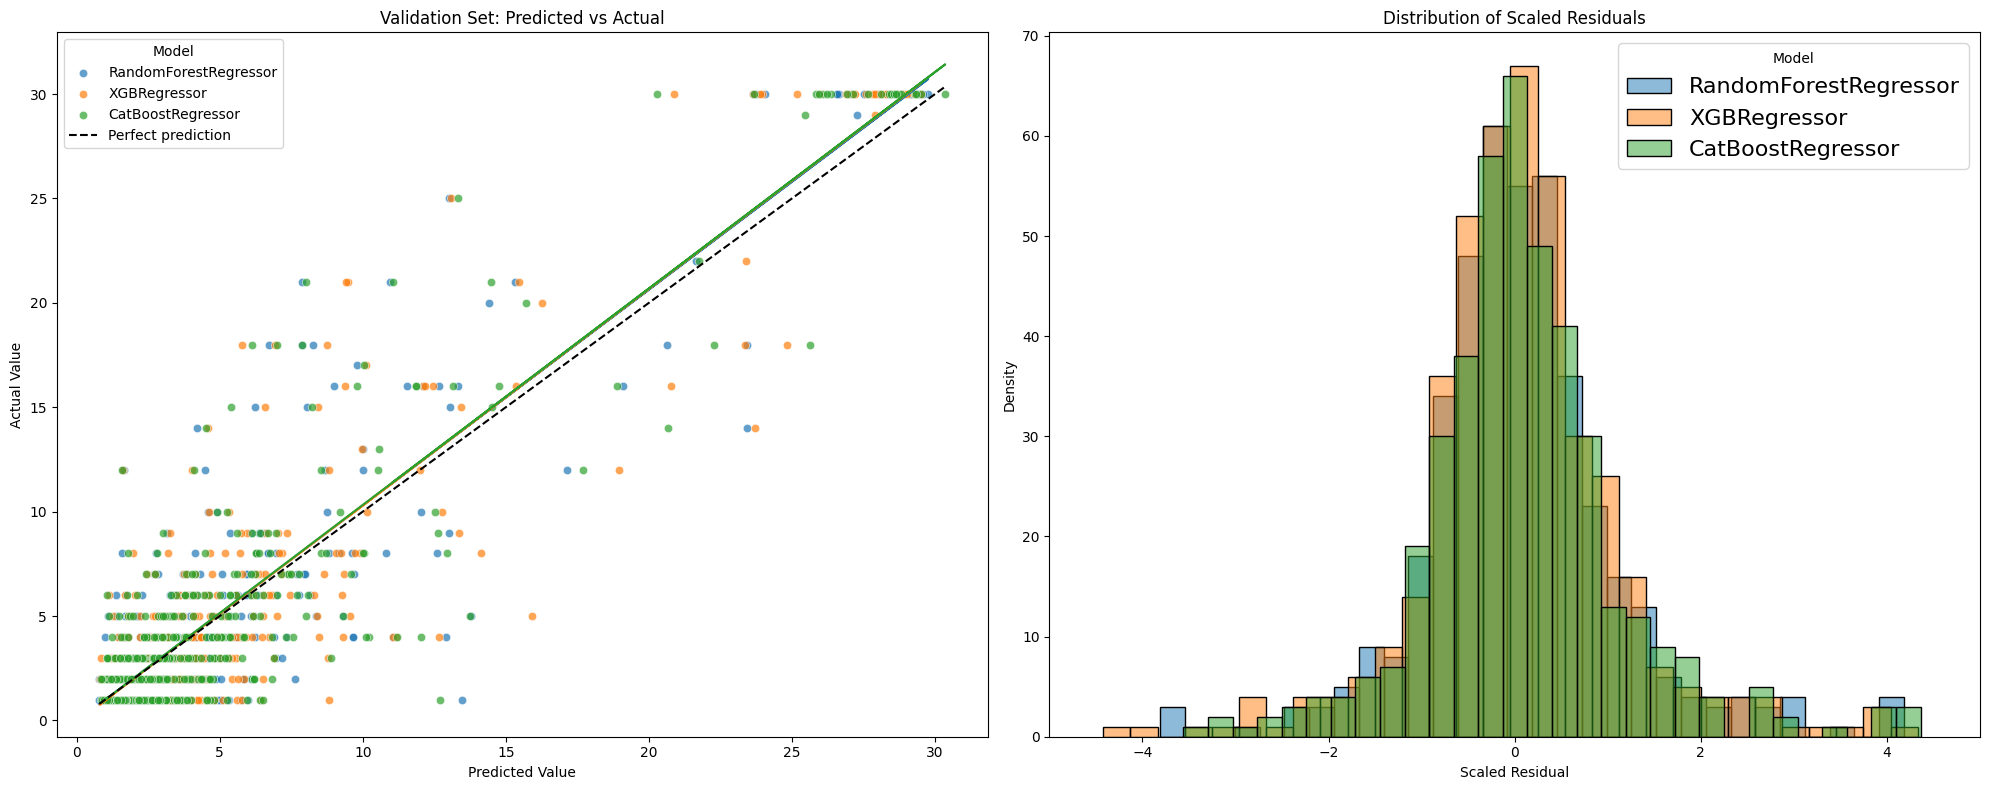

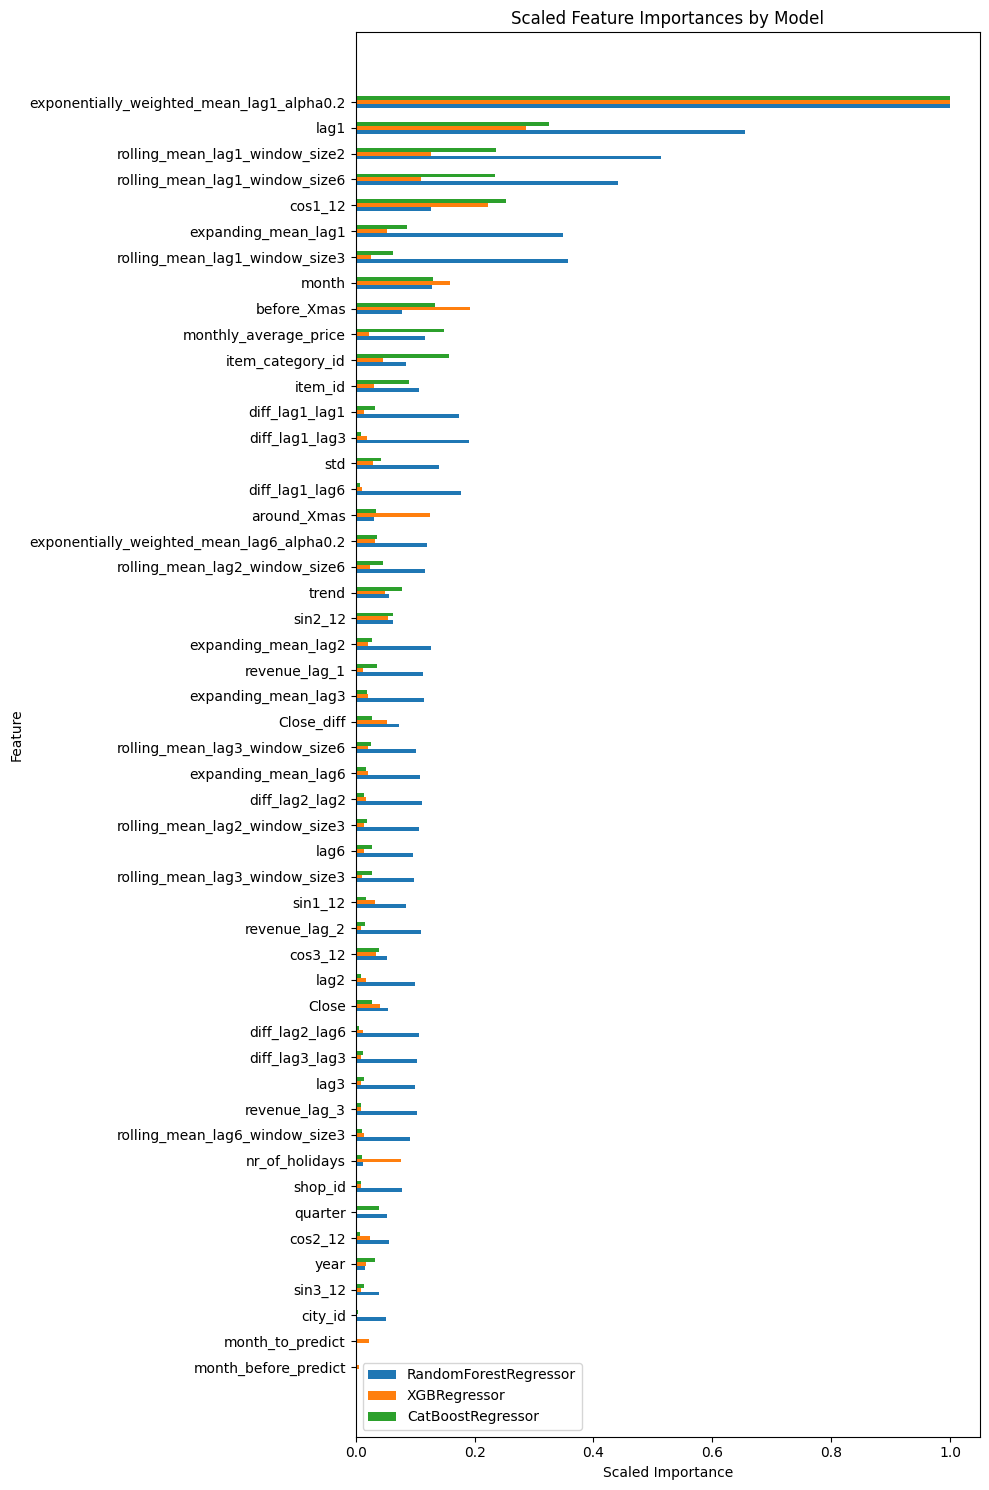

In [2463]:
# Assuming you have your fcst object and valid set ready
evaluator = MLForecast_Evaluator(fcst, valid, future_df, h=1)

# Plot time series
evaluator.plot_time_series(n_samples=6)  # Will show 4 random time series in a 2x2 grid

# Calculate and print metrics
evaluator.calculate_metrics()

# Plot metrics
evaluator.plot_metrics()

# Plot feature importances sorted by the average importance
evaluator.plot_feature_importances()

# Explainer

In [2517]:
fcst.fit(train.drop(static_features, axis=1).dropna(), fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=[])

MLForecast(models=[RandomForestRegressor, XGBRegressor, CatBoostRegressor], freq=M, lag_features=['lag1', 'lag2', 'lag3', 'lag6', 'rolling_mean_lag1_window_size2', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6', 'diff_lag1_lag1', 'diff_lag1_lag3', 'diff_lag1_lag6', 'expanding_mean_lag1', 'exponentially_weighted_mean_lag1_alpha0.2', 'rolling_mean_lag2_window_size3', 'rolling_mean_lag2_window_size6', 'diff_lag2_lag2', 'diff_lag2_lag6', 'expanding_mean_lag2', 'rolling_mean_lag3_window_size3', 'rolling_mean_lag3_window_size6', 'diff_lag3_lag3', 'expanding_mean_lag3', 'rolling_mean_lag6_window_size3', 'expanding_mean_lag6', 'exponentially_weighted_mean_lag6_alpha0.2'], date_features=[], num_threads=6)

In [2518]:
import shap
prep = fcst.preprocess(train.drop(static_features, axis=1).dropna())
X = prep.drop(columns=['unique_id', 'ds', 'y'])
int_columns = X.select_dtypes('int').columns.to_list()
#X = X.drop(columns=int_columns)

In [2519]:
for col in X.columns:
    if X[col].dtype.kind != 'f':
        X[col] = X[col].astype("float64")

In [2520]:
X100 = shap.utils.sample(X, 100)
explainer = shap.Explainer(fcst.models_['RandomForestRegressor'].predict, X100)

In [2521]:
shap_values = explainer(X)

PermutationExplainer explainer: 9373it [2:21:18,  1.10it/s]                            


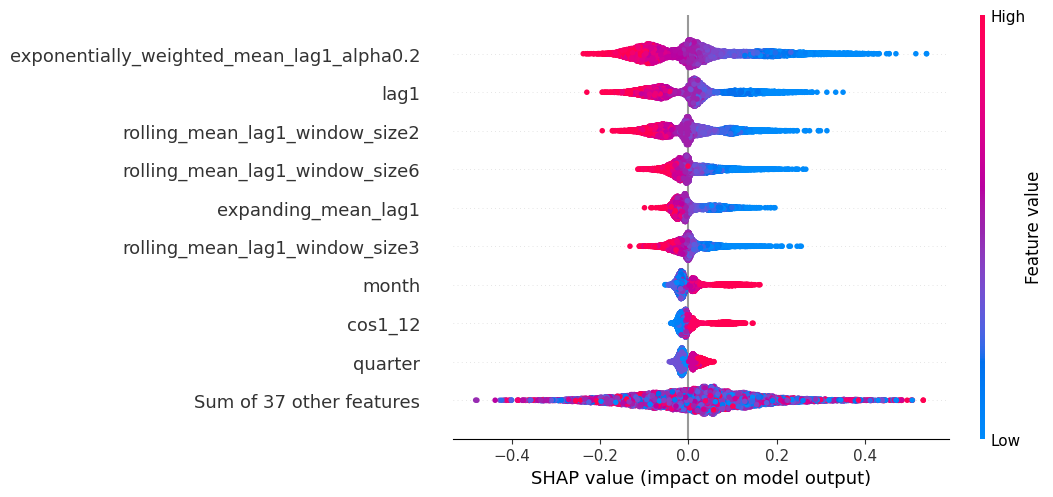

In [2523]:
shap.plots.beeswarm(shap_values)

In [2524]:
np.abs(shap_values.values).mean(0)

array([0.00660876, 0.02325908, 0.00302245, 0.01765884, 0.00538713,
       0.01354601, 0.00705863, 0.01181654, 0.00909766, 0.00350535,
       0.01797512, 0.00377376, 0.00563944, 0.00152671, 0.00013676,
       0.00015254, 0.00505212, 0.00393926, 0.00329491, 0.00418099,
       0.00805969, 0.0067046 , 0.06376928, 0.0045906 , 0.00567234,
       0.0061987 , 0.055136  , 0.0261104 , 0.03452949, 0.01431944,
       0.00841387, 0.0091527 , 0.02955947, 0.09072392, 0.00676145,
       0.01159313, 0.00526939, 0.00405506, 0.00450143, 0.00384352,
       0.00564855, 0.0033659 , 0.00593909, 0.00316182, 0.00607719,
       0.00517387])

In [2526]:
from mlforecast.callbacks import SaveFeatures

save_feats = SaveFeatures()

In [2529]:
preds = fcst.predict(1, before_predict_callback=save_feats)
features = save_feats.get_features()

In [2534]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5112 entries, 0 to 5111
Data columns (total 46 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   monthly_average_price                      5112 non-null   float64
 1   month                                      5112 non-null   int64  
 2   year                                       5112 non-null   int64  
 3   quarter                                    5112 non-null   int64  
 4   around_Xmas                                5112 non-null   bool   
 5   before_Xmas                                5112 non-null   bool   
 6   trend                                      5112 non-null   float32
 7   sin1_12                                    5112 non-null   float32
 8   sin2_12                                    5112 non-null   float32
 9   sin3_12                                    5112 non-null   float32
 10  cos1_12                 

In [2532]:
shap_values_predictions = explainer(features)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:

shap.plots.waterfall(shap_values_predictions[4])


# Predicting future values (test)

In [ ]:
# Predict h=2 and save second prediction as submission
#evaluator = MLForecast_Evaluator(fcst, valid, future_df, h=2)
#evaluator.calculate_metrics()

#for model in evaluator.model_columns:
model = 'CatBoostRegressor'
#evaluator.predict_save_submission(model, test_index=test_index)

# Correlation?

In [2624]:
train.drop(columns=static_features+core_features, axis=1).dropna().corr().style.background_gradient(cmap='coolwarm')

,monthly_average_price,y,month,year,quarter,around_Xmas,before_Xmas,trend,sin1_12,sin2_12,sin3_12,cos1_12,cos2_12,cos3_12,nr_of_holidays,month_to_predict,month_before_predict,revenue_lag_1,revenue_lag_2,revenue_lag_3,Close,Close_diff,std,revenue
monthly_average_price,1.000000,-0.128324,-0.012427,0.045036,-0.011289,-0.009639,-0.008161,0.042433,0.011201,0.003013,-0.008086,-0.014838,-0.002046,0.003840,0.000082,-0.008179,-0.011911,0.187970,0.068304,0.080983,0.054927,-0.003989,-0.003641,0.556676
y,-0.128324,1.000000,0.021031,-0.025746,0.010982,0.123078,0.115774,-0.019207,0.021028,0.037689,-0.000681,0.126944,0.014013,0.025961,0.068553,-0.008277,-0.005667,0.109234,0.110834,0.083246,0.012734,0.049832,0.548346,0.441448
month,-0.012427,0.021031,1.000000,-0.288219,0.969037,0.040190,0.472690,0.062262,-0.784280,-0.267967,-0.155118,0.150851,0.242240,0.221474,-0.718805,0.310774,0.229816,0.004034,-0.009160,-0.019951,-0.095194,0.225486,0.000000,0.012191
year,0.045036,-0.025746,-0.288219,1.000000,-0.265899,0.047946,-0.136305,0.937761,0.178114,0.156351,0.053974,-0.108525,0.026743,0.000000,0.209026,-0.136305,-0.136305,0.003428,0.008061,0.012317,0.861479,0.103405,-0.000000,0.001334
quarter,-0.011289,0.010982,0.969037,-0.265899,1.000000,0.040692,0.396626,0.074297,-0.803065,-0.271315,-0.157056,0.147422,0.245267,0.252271,-0.710706,0.396626,0.150718,-0.003916,-0.014892,-0.023468,-0.083039,0.248889,-0.000000,0.003473
around_Xmas,-0.009639,0.123078,0.040190,0.047946,0.040692,1.000000,0.682288,0.064550,0.102861,0.218907,0.294831,0.575624,0.420543,0.267879,0.442277,-0.101080,-0.101080,0.109582,0.103180,0.101469,0.215317,0.434070,0.000000,0.115108
before_Xmas,-0.008161,0.115774,0.472690,-0.136305,0.396626,0.682288,1.000000,0.029361,-0.022257,-0.010300,0.012192,0.418105,0.380562,0.365542,-0.143695,-0.068966,-0.068966,0.092943,0.079859,0.070619,0.063707,0.157178,0.000000,0.102662
trend,0.042433,-0.019207,0.062262,0.937761,0.074297,0.064550,0.029361,1.000000,-0.098789,0.065779,0.000000,-0.058405,0.115728,0.080322,-0.042823,-0.029361,-0.058722,0.005036,0.005080,0.005602,0.863387,0.189555,-0.000000,0.005812
sin1_12,0.011201,0.021028,-0.784280,0.178114,-0.803065,0.102861,-0.022257,-0.098789,1.000000,-0.106376,0.003934,0.041095,-0.090871,-0.054750,0.538989,-0.342472,-0.392009,0.033141,0.040980,0.046267,0.048137,-0.302431,-0.000000,0.027786
sin2_12,0.003013,0.037689,-0.267967,0.156351,-0.271315,0.218907,-0.010300,0.065779,-0.106376,1.000000,-0.111074,0.034172,-0.027067,-0.054596,0.444263,-0.329617,-0.010301,0.028747,0.029122,0.031392,0.205837,0.153355,0.000000,0.027916


# Variance time series exploration

In [2544]:
data2 = data.copy()
data2['y_log'] = data2['y'].apply(np.log1p)
data2['y_log_diff'] = data2['y_log'].diff()

variances = data2.groupby('unique_id')['y']\
                                            .agg()\
                                                .to_frame('var').sort_values(by='var')
variances

,var
unique_id,
31_12064,0.799465
31_12558,0.920677
31_10334,1.204991
31_3656,1.543672
35_2252,1.544563
...,...
4_17717,117.259358
6_17717,126.254011
31_17717,139.508021


In [2547]:
# Step 1: Apply log transformation to y
data2 = data.copy()
data2['y_log'] = data2['y'].apply(np.log1p)

# Step 2: Compute the first difference of the log-transformed y
data2['y_log_diff'] = data2['y_log'].diff()

# Step 3: Calculate variances and standard deviations
variances = data2.groupby('unique_id')['y'].var().to_frame('var_y').sort_values(by='var_y')
variances['var_y_log'] = data2.groupby('unique_id')['y_log'].var()
variances['var_y_log_diff'] = data2.groupby('unique_id')['y_log_diff'].var()

std_devs = data2.groupby('unique_id')['y'].std().to_frame('std_y').sort_values(by='std_y')
std_devs['std_y_log'] = data2.groupby('unique_id')['y_log'].std()
std_devs['std_y_log_diff'] = data2.groupby('unique_id')['y_log_diff'].std()

In [2566]:
data['variance'] = data.groupby('unique_id')['y'].transform(np.var)
data['std'] = data.groupby('unique_id')['y'].transform(np.std)

In [2571]:
train.groupby('unique_id')['y'].describe().T.style.background_gradient(cmap='coolwarm')

# 4 clusters

In [2584]:
from sklearn.cluster import KMeans

desc_stats = train.groupby('unique_id')['y'].describe()
desc_stats_for_clustering = desc_stats.drop(columns=['count'])
kmeans = KMeans(n_clusters=4, random_state=0).fit(desc_stats_for_clustering)
desc_stats['cluster'] = kmeans.labels_
train2 = train.merge(desc_stats[['cluster']], on='unique_id')
train2.groupby('cluster')['y'].describe().drop(columns=['count']).style.background_gradient(cmap='coolwarm')

,mean,std,min,25%,50%,75%,max
cluster,,,,,,,
0,12.617535,8.320422,0.000000,6.000000,11.000000,18.000000,30.000000
1,3.667987,2.708142,0.000000,2.000000,3.000000,5.000000,17.000000
2,28.057639,5.624867,0.000000,30.000000,30.000000,30.000000,30.000000
3,6.746104,5.294811,0.000000,3.000000,6.000000,9.000000,30.000000


<Axes: xlabel='ds', ylabel='y'>

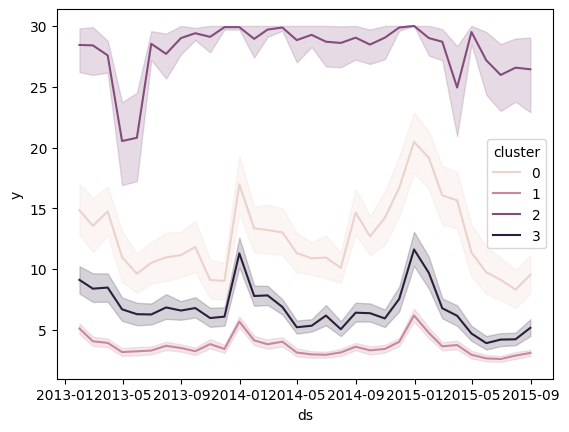

In [2585]:
sns.lineplot(x='ds', y='y', hue='cluster', data=train2)

# 3 Clusters

In [2600]:
grouped_df = (
    train2.groupby(['cluster'] + [pd.Grouper(key='ds', freq='M')])
    ['y']
    .agg(np.mean)
    .reset_index()
)
grouped_df

,cluster,ds,y
0,0,2013-01-31,12.083333
1,0,2013-02-28,11.386364
2,0,2013-03-31,11.861111
3,0,2013-04-30,8.919192
4,0,2013-05-31,8.151515
...,...,...,...
91,2,2015-04-30,29.096774
92,2,2015-05-31,26.870968
93,2,2015-06-30,25.645161
94,2,2015-07-31,26.129032


In [2598]:
train2.groupby('cluster')['y'].agg(['mean','std','var']).style.background_gradient(cmap='coolwarm')

,mean,std,var
cluster,,,
0,9.651752,7.468168,55.773530
1,4.081195,3.174656,10.078440
2,27.820901,5.849637,34.218255


In [2592]:
from sklearn.cluster import KMeans

desc_stats = train.groupby('unique_id')['y'].describe()
desc_stats_for_clustering = desc_stats.drop(columns=['count'])
kmeans = KMeans(n_clusters=3, random_state=0).fit(desc_stats_for_clustering)
desc_stats['cluster'] = kmeans.labels_
train2 = train.merge(desc_stats[['cluster']], on='unique_id')
train2.groupby('cluster')['y'].describe().drop(columns=['count']).style.background_gradient(cmap='coolwarm')

,mean,std,min,25%,50%,75%,max
cluster,,,,,,,
0,9.651752,7.468168,0.000000,4.000000,8.000000,13.000000,30.000000
1,4.081195,3.174656,0.000000,2.000000,3.000000,5.333333,23.000000
2,27.820901,5.849637,0.000000,30.000000,30.000000,30.000000,30.000000


<Axes: xlabel='ds', ylabel='y'>

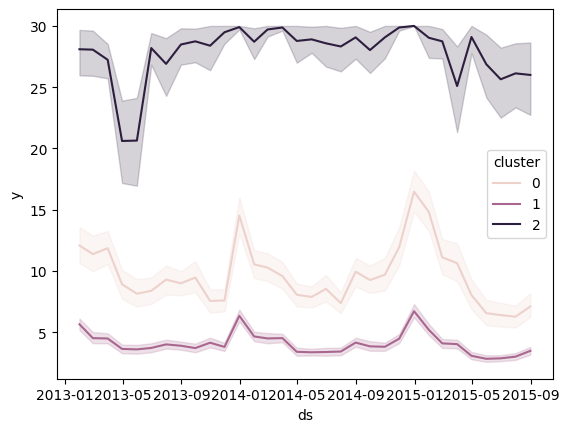

In [2593]:
sns.lineplot(x='ds', y='y', hue='cluster', data=train2)

<Axes: xlabel='var_y_log_diff', ylabel='Count'>

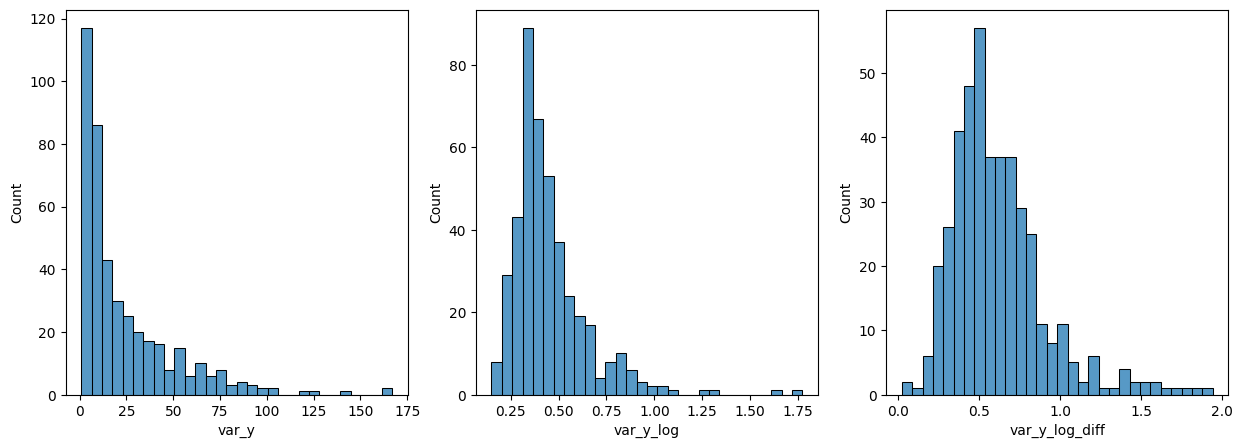

In [2560]:
fig = plt.figure(figsize = (15, 5))
ax1, ax2, ax3 = fig.subplots(1, 3)
sns.histplot(data=variances['var_y'], bins=30, ax=ax1)
sns.histplot(data=variances['var_y_log'], bins=30, ax=ax2)
sns.histplot(data=variances['var_y_log_diff'], bins=30, ax=ax3)

<Axes: xlabel='std_y_log_diff', ylabel='Count'>

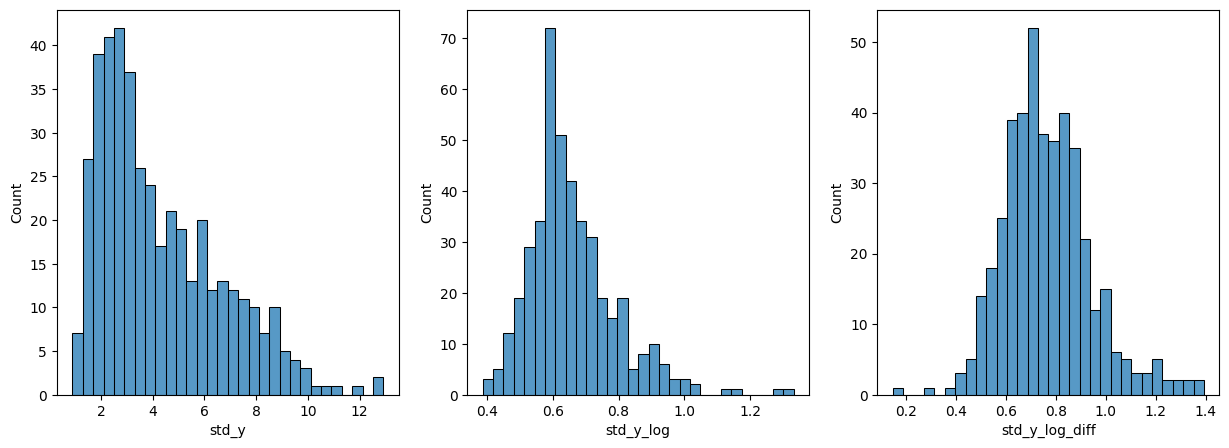

In [2565]:
fig = plt.figure(figsize = (15, 5))
ax1, ax2, ax3 = fig.subplots(1, 3)
sns.histplot(data=std_devs['std_y'], bins=30, ax=ax1)
sns.histplot(data=std_devs['std_y_log'], bins=30, ax=ax2)
sns.histplot(data=std_devs['std_y_log_diff'], bins=30, ax=ax3)

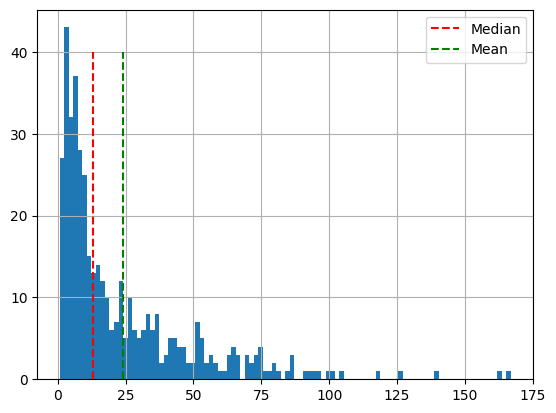

In [ ]:
variances['var'].hist(bins=100)
plt.vlines(variances['var'].median(), color='r', ls='--', ymax=40, ymin=0, label='Median')
plt.vlines(variances['var'].mean(), color='g', ls='--', ymax=40, ymin=0, label='Mean')
plt.legend();

In [ ]:
low_var_ids = variances[variances['var'] <= variances['var'].mean()].index
print("Low variance time series:", len(low_var_ids))
low_var_ids = low_var_ids[:10]

high_var_ids = variances[variances['var'] > variances['var'].mean()].index
print("High variance time series:", len(high_var_ids))
high_var_ids = high_var_ids[-10:]

Low variance time series: 281
High variance time series: 145


In [ ]:
"""fig = plt.figure(figsize = (15, 5))
ax1, ax2 = fig.subplots(1, 2)

sns.lineplot(data = data2[data2['unique_id'].isin(low_var_ids)], x = "ds", 
             y = "y_log_diff", hue='unique_id', legend=False, ax=ax1);
ax1.set_title("Low variance time series");

sns.lineplot(data = data2[data2['unique_id'].isin(low_var_ids)], x = "ds", 
             y = "y_log_diff", legend=False, ax=ax2);
ax2.set_title("Aggregated low variance time series");"""

'fig = plt.figure(figsize = (15, 5))\nax1, ax2 = fig.subplots(1, 2)\n\nsns.lineplot(data = data2[data2[\'unique_id\'].isin(low_var_ids)], x = "ds", \n             y = "y_log_diff", hue=\'unique_id\', legend=False, ax=ax1);\nax1.set_title("Low variance time series");\n\nsns.lineplot(data = data2[data2[\'unique_id\'].isin(low_var_ids)], x = "ds", \n             y = "y_log_diff", legend=False, ax=ax2);\nax2.set_title("Aggregated low variance time series");'

In [ ]:
"""
fig = plt.figure(figsize = (15, 5))
ax1, ax2 = fig.subplots(1, 2)

sns.lineplot(data = data2[data2['unique_id'].isin(high_var_ids)], x = "ds", 
             y = "y_log_diff", hue='unique_id', legend=False, ax=ax1);
plt.xticks(rotation=45);
ax1.set_title("Low variance time series");

sns.lineplot(data = data2[data2['unique_id'].isin(high_var_ids)], x = "ds", 
             y = "y_log_diff", legend=False, ax=ax2);
plt.xticks(rotation=45);
ax2.set_title("Aggregated low variance time series");
"""

'\nfig = plt.figure(figsize = (15, 5))\nax1, ax2 = fig.subplots(1, 2)\n\nsns.lineplot(data = data2[data2[\'unique_id\'].isin(high_var_ids)], x = "ds", \n             y = "y_log_diff", hue=\'unique_id\', legend=False, ax=ax1);\nplt.xticks(rotation=45);\nax1.set_title("Low variance time series");\n\nsns.lineplot(data = data2[data2[\'unique_id\'].isin(high_var_ids)], x = "ds", \n             y = "y_log_diff", legend=False, ax=ax2);\nplt.xticks(rotation=45);\nax2.set_title("Aggregated low variance time series");\n'

---

# Results

## Recordar probar todo de nuevo sin transf target y sin 6

### First Benchmark: 
- Train RMSE: 3_448
- Validation RMSE: 3_049

### After optimizing initial setup:

MEAN RMSE_VALID = 2.813796376427073

Model with lowest RMSE validation is CatBoostRegressor with RMSE = 2.7846076094047794

| Model                  | RMSE_train | R2_train | RMSE_valid | R2_valid |
|------------------------|------------|----------|------------|----------|
| CatBoostRegressor      | 3.310010   | 0.833930 | 2.784608   | 0.857553 |
| XGBRegressor           | 2.683747   | 0.890827 | 2.823385   | 0.853558 |
| RandomForestRegressor  | 2.523173   | 0.903500 | 2.833397   | 0.852517 |


---

# Hyperparam

https://forecastegy.com/posts/multiple-time-series-forecasting-with-xgboost-in-python/

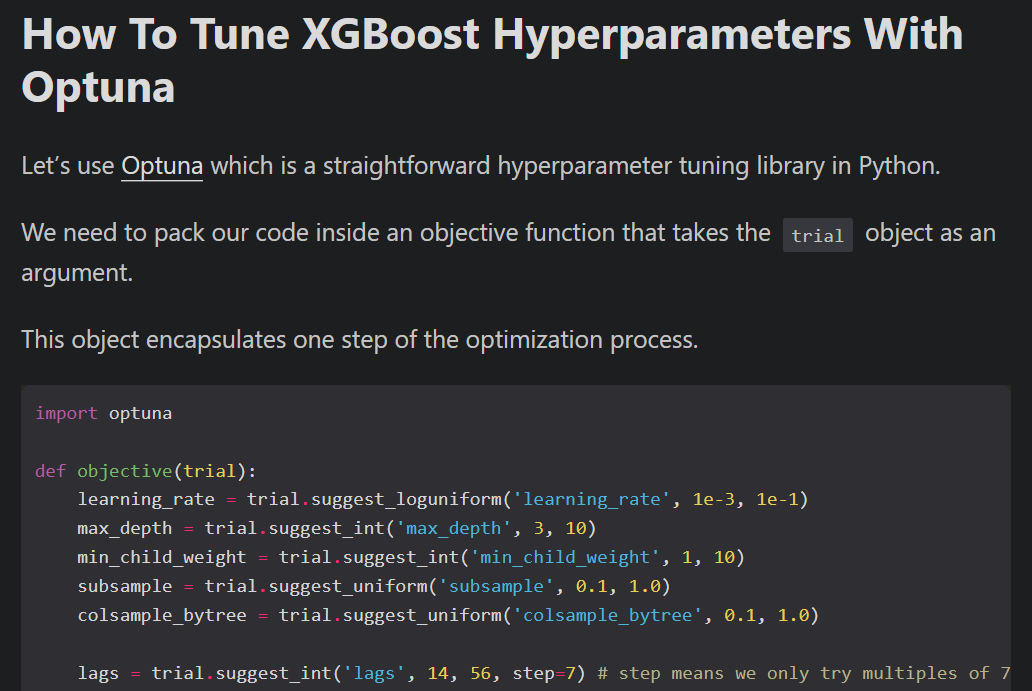

### Test 1 - No overffiting control, only initial variables
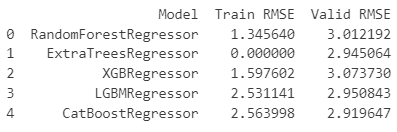

### Test 2 - Adding overffiting control
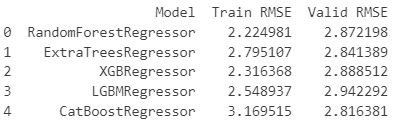